# What causes flanking pairs to be reactive?

## Setup

### imports

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress, zscore
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm

from dms_3d_features.plotting import plot_pop_avg_from_row, publication_style_ax, plot_motif_boxplot_stripplot


### extra functions

In [2]:
def plot_violinplot_w_percent(df: pd.DataFrame, x: str, y: str, cutoff=-5.65, color="tab:blue", gt_lt="greater", ax=None) -> plt.Axes:
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    sns.violinplot(x=x, y=y, data=df, color=color, density_norm='width', ax=ax)
    ax.axvline(cutoff, color='red', linestyle='--')
    count = 0
    for group_name, g in df.groupby(y):
        if gt_lt == "greater":
            percent = (g[x] > cutoff).sum() / len(g)
        elif gt_lt == "less":
            percent = (g[x] < cutoff).sum() / len(g)
        ax.text(-8.5, count, f"{percent:.2f}", va='center', ha='right')
        print(group_name, percent)
        count += 1
    return ax

In [3]:
def format_small_plot(ax):
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)
    plt.subplots_adjust(left=0.3, bottom=0.21, top=0.98)

### load data

In [4]:
DATA_PATH = "../data"

In [5]:
df_constructs = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1_combined.json")
df_constructs_nomod = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_nomod.json")
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df["ln_r_data"] = np.log(df["r_data"])
df['ln_r_data'].replace(-np.inf, -9.8, inplace=True)

df["z_score"] = 0
df["r_data_outlier"] = False
data = []
for i, g in df.groupby(["m_sequence", "r_loc_pos"]):
    g["z_score"] = zscore(g["r_data"])
    g["r_data_outlier"] = g["z_score"].abs() > 3
    data.append(g)
df = pd.concat(data)
df = df.query("r_data_outlier == False").copy()

df_residue_avg = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_avg.json")
df_residue_avg = df_residue_avg.query("r_type == 'WC'").copy()
df_wc = df.query("r_type == 'WC'").copy()

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
df_wc.sort_values("ln_r_data", inplace=True, ascending=False)
df_wc_high = df_wc.query("ln_r_data > -5.45").copy()
df_wc_high.sort_values("ln_r_data", inplace=True, ascending=False)


In [7]:
df_residue_avg.sort_values("r_data", inplace=True, ascending=False)
first_10_unique = df_residue_avg.drop_duplicates(subset='m_sequence', keep='first').head(50)


## plotting

### trends over entire set 

#### As are more reactive than Cs in flanking pairs

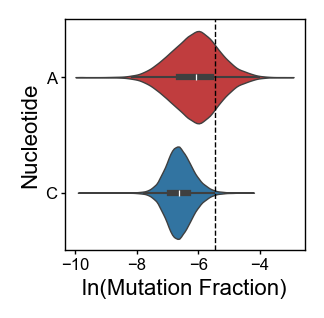

In [8]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
ax = sns.violinplot(data=df_wc, x="ln_r_data", y="r_nuc", hue="r_nuc", density_norm='width', palette=["tab:red", "tab:blue"], legend=False, linewidth=0.5, ax=ax)
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
ax.set_ylabel("Nucleotide", labelpad=2)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
ax.set_xticks([-10, -8, -6, -4])
format_small_plot(ax)

In [9]:
for r_nuc, g in df_wc.groupby("r_nuc"):
    g_sub = g.query("ln_r_data > -5.45")
    print(r_nuc, round(len(g_sub) / len(g) * 100, 2), len(g))

A 19.56 47652
C 1.01 52121


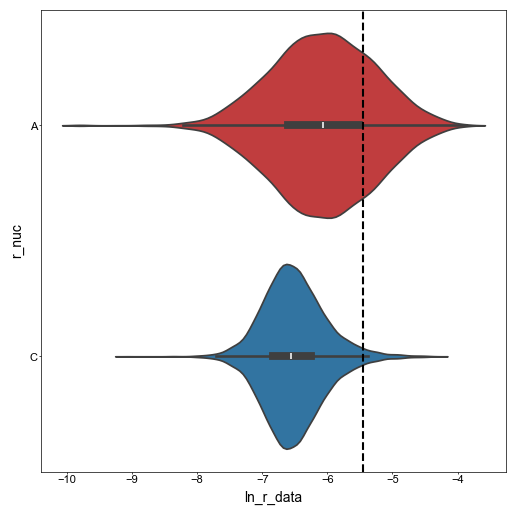

In [10]:
df_wc_pdb = df_wc.query("has_pdbs == True").copy()
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.violinplot(data=df_wc_pdb, x="ln_r_data", y="r_nuc", hue="r_nuc", density_norm='width', palette=["tab:red", "tab:blue"], legend=False, ax=ax)
ax.axvline(-5.45, color="black", linestyle="--")
publication_style_ax(ax)

### check to see how many A vs Cs there are 

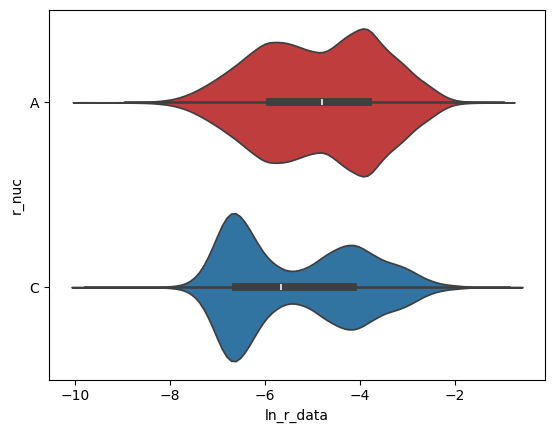

In [11]:
sns.violinplot(data=df, x="ln_r_data", y="r_nuc", hue="r_nuc", density_norm='width', palette=["tab:red", "tab:blue"], legend=False);

### by m_token

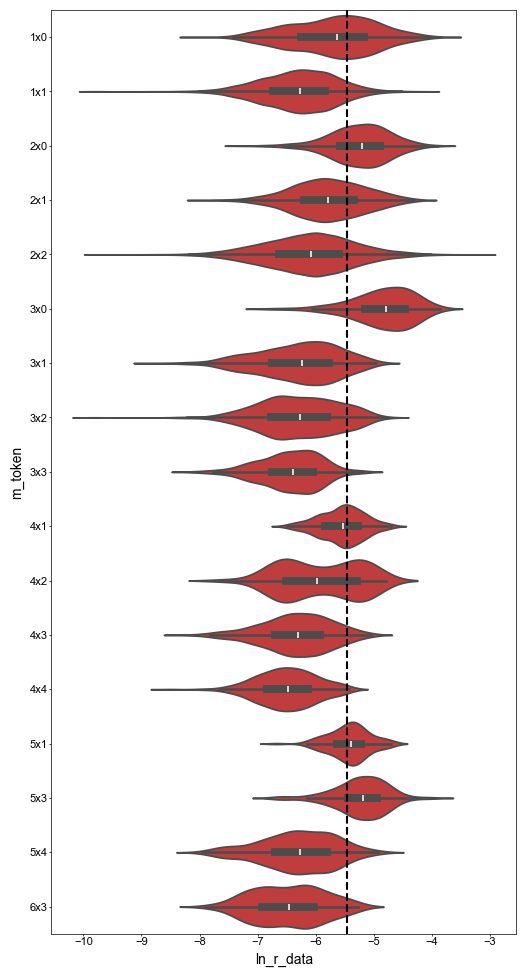

In [12]:
df_pos = df_wc.query("r_nuc == 'A'").copy()
df_pos.sort_values("m_token", inplace=True, ascending=True)
fig, ax = plt.subplots(figsize=(6, 12))
ax = sns.violinplot(data=df_pos, x="ln_r_data", y="m_token", density_norm='width', color='tab:red');
ax.axvline(-5.45, color="black", linestyle="--")
publication_style_ax(ax)


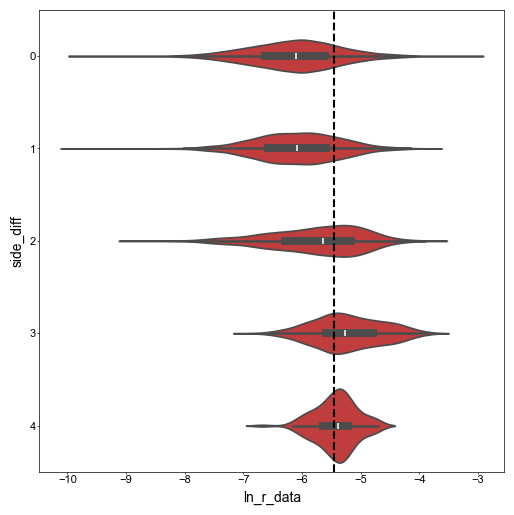

In [13]:
df_pos = df_wc.query("r_nuc == 'A' and m_token != '6x3'").copy()
df_pos["side_diff"] = [abs(int(x.split("x")[0]) - int(x.split("x")[1])) for x in df_pos["m_token"]]
df_pos["side_diff"] = df_pos["side_diff"].astype(str)
df_pos.sort_values("side_diff", inplace=True, ascending=True)
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.violinplot(data=df_pos, x="ln_r_data", y="side_diff", color='tab:red', ax=ax);
ax.axvline(-5.45, color="black", linestyle="--")
publication_style_ax(ax)



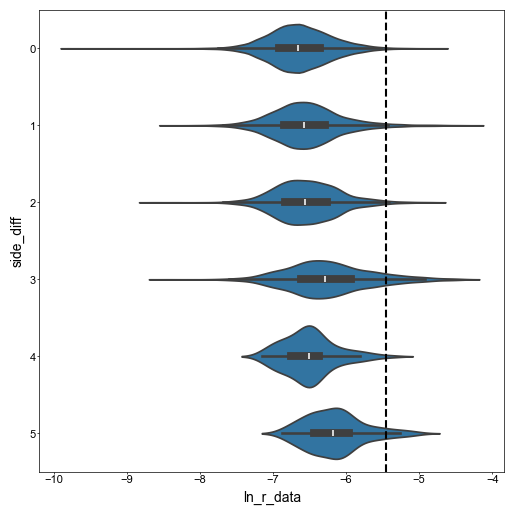

In [14]:
df_pos = df_wc.query("r_nuc == 'C' and m_token != '6x3'").copy()
df_pos["side_diff"] = [abs(int(x.split("x")[0]) - int(x.split("x")[1])) for x in df_pos["m_token"]]
df_pos["side_diff"] = df_pos["side_diff"].astype(str)
df_pos.sort_values("side_diff", inplace=True, ascending=True)
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.violinplot(data=df_pos, x="ln_r_data", y="side_diff", color='tab:blue', ax=ax);
ax.axvline(-5.45, color="black", linestyle="--")
publication_style_ax(ax)

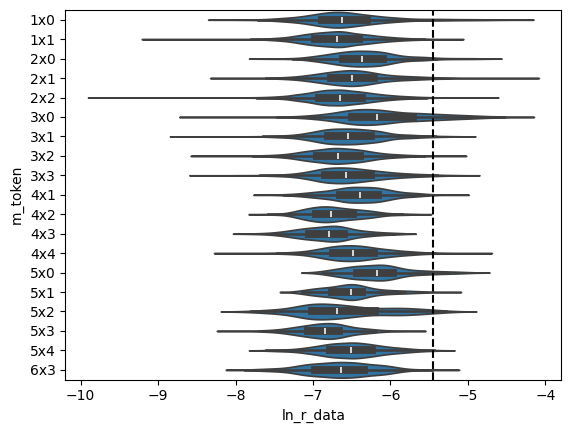

In [15]:
df_pos = df_wc.query("r_nuc == 'C'").copy()
df_pos.sort_values("m_token", inplace=True, ascending=True)
ax = sns.violinplot(data=df_pos, x="ln_r_data", y="m_token", density_norm='width');
ax.axvline(-5.45, color="black", linestyle="--")


### position 1 analysis

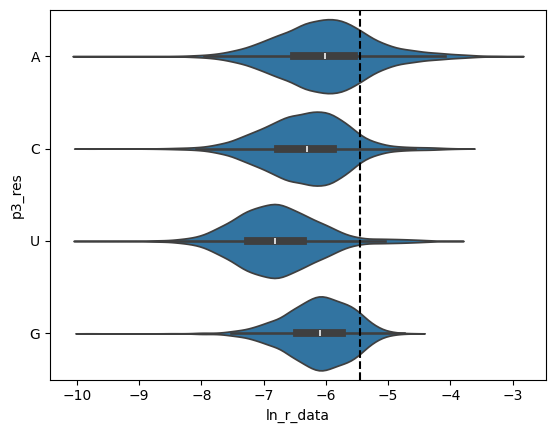

In [16]:
df_pos = df_wc.query("r_loc_pos == 0 and r_nuc == 'A'").copy()
ax = sns.violinplot(data=df_pos, x="ln_r_data", y="p3_res", density_norm='width', legend=False);
ax.axvline(-5.45, color="black", linestyle="--")

In [17]:
df_pos = df_wc.query("r_loc_pos == 0 and r_nuc == 'A'").copy()
for stack, g in df_pos.query("r_nuc == 'A'").groupby("p3_res"):
    g_sub = g.query("ln_r_data > -5.45")
    print(stack, len(g_sub) / len(g) * 100)

A 20.827429866817795
C 7.627422828427853
G 9.122930609369497
U 3.629436534990976


In [18]:
df_pos = df_wc.query("r_loc_pos == 0").copy()
stack = []
for i, row in df_pos.iterrows():
    stack.append(row["m_second_flank_bp_5p"][0] + row["p3_res"])
df_pos["stack"] = stack

In [19]:
for stack, g in df_pos.query("r_nuc == 'A'").groupby("stack"):
    g_sub = g.query("ln_r_data > -5.45")
    print(stack, len(g_sub) / len(g) * 100)

AA 21.47470398277718
AC 8.630527817403708
AG 9.137055837563452
AU 4.963971176941554
CA 24.769992922859167
CC 8.090075062552128
CG 10.603290676416819
CU 4.797742238946378
GA 27.129120879120876
GC 12.244897959183673
GG 16.049382716049383
GU 5.187319884726225
UA 13.985413985413986
UC 3.7418655097613884
UG 4.055496264674493
UU 0.8567931456548347


In [20]:
for stack, g in df_pos.query("r_nuc == 'C'").groupby("stack"):
    g_sub = g.query("ln_r_data > -5.45")
    print(stack, len(g_sub) / len(g) * 100)

AA 0.9994121105232217
AC 3.9247751430907605
AG 0.7106598984771574
AU 0.0
CA 0.11723329425556857
CC 0.4629629629629629
CG 0.24271844660194172
CU 0.0
GA 0.24242424242424243
GC 1.0810810810810811
GG 0.26109660574412535
GU 0.0
UA 0.24198427102238357
UC 1.3513513513513513
UG 0.2915451895043732
UU 0.0


In [21]:
df_final = df_pos.query("r_nuc == 'A'").copy().sort_values("stack", ascending=True)
df_final['ln_r_data_bins'] = pd.cut(df_final['ln_r_data'], bins=25)

In [22]:
heatmap_data = df_final.pivot_table(index="stack", columns="ln_r_data_bins", values="ln_r_data", aggfunc="count")

<Axes: xlabel='ln_r_data_bins', ylabel='stack'>

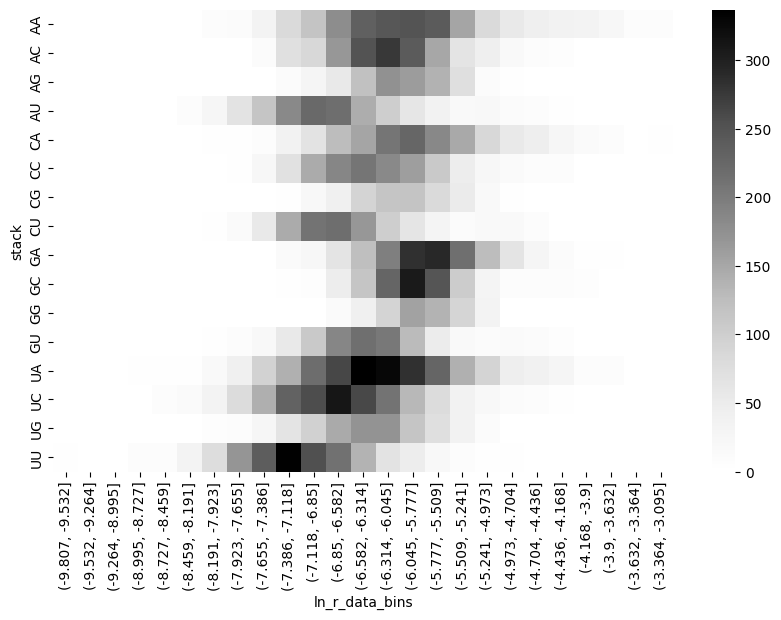

In [23]:
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap="Greys")

In [24]:
for stack, g in df_pos.query("r_nuc == 'C'").groupby("stack"):
    g_sub = g.query("ln_r_data > -5.45")
    print(stack, len(g_sub) / len(g) * 100)

AA 0.9994121105232217
AC 3.9247751430907605
AG 0.7106598984771574
AU 0.0
CA 0.11723329425556857
CC 0.4629629629629629
CG 0.24271844660194172
CU 0.0
GA 0.24242424242424243
GC 1.0810810810810811
GG 0.26109660574412535
GU 0.0
UA 0.24198427102238357
UC 1.3513513513513513
UG 0.2915451895043732
UU 0.0


/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_61305/1403191068.py:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(data=df_target, x="ln_r_data", y="stack", scale="width")


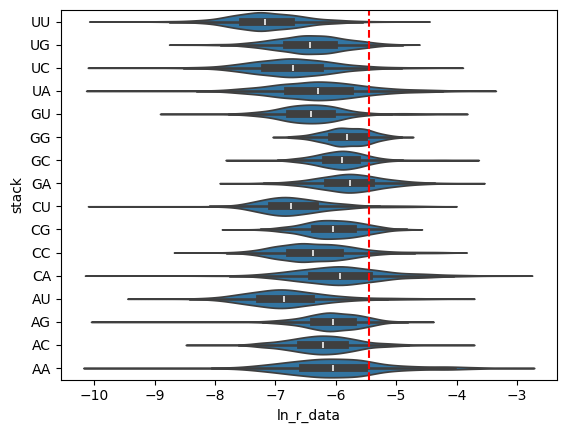

In [25]:
df_target = df_pos.query("r_nuc == 'A'").sort_values("stack", ascending=False)
ax = sns.violinplot(data=df_target, x="ln_r_data", y="stack", scale="width")
ax.axvline(-5.45, color="red", linestyle="--")

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:378: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


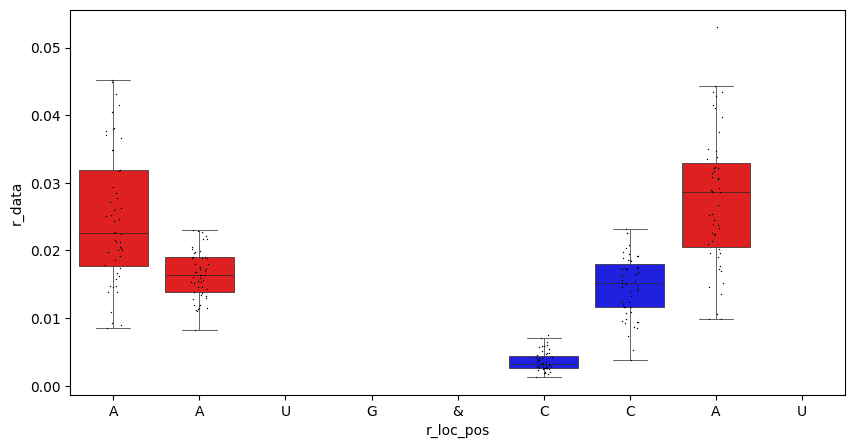

In [26]:
for m_sequence in first_10_unique["m_sequence"].values:
    plot_motif_boxplot_stripplot(df.query("m_sequence == @m_sequence"));
    break

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:378: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


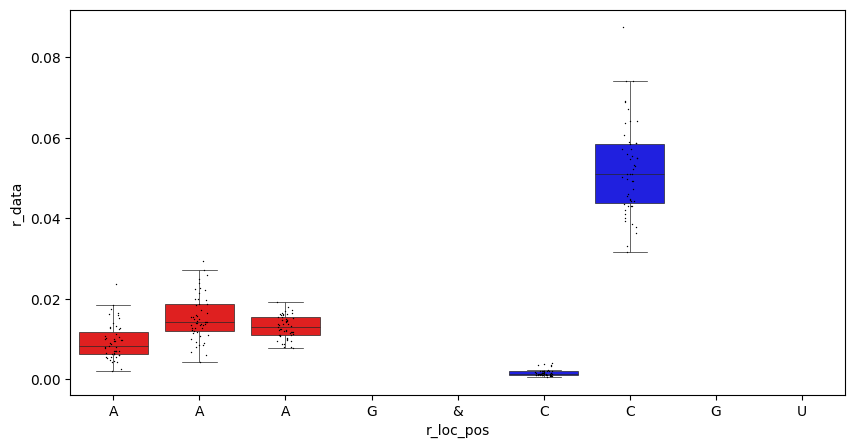

In [27]:
plot_motif_boxplot_stripplot(df.query("m_sequence == 'AAAG&CCGU'"));

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:378: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


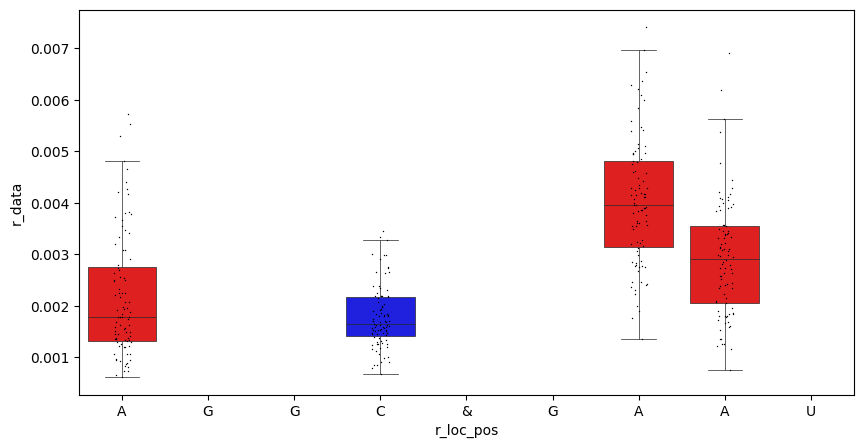

In [28]:
plot_motif_boxplot_stripplot(df.query("m_sequence == 'AGGC&GAAU'"));

#### AGGC&GAAU

In [29]:
df_wc.query("m_sequence == 'AGGC&GAAU' and r_loc_pos == 0 and ln_r_data > -5.45")

,both_purine,both_pyrimidine,constructs,has_pdbs,likely_pair,m_flank_bp_5p,m_flank_bp_3p,m_orientation,m_pos,m_second_flank_bp_5p,...,r_data,r_nuc,r_loc_pos,r_pos,r_type,pdb_path,pdb_r_pos,ln_r_data,z_score,r_data_outlier
72600,False,False,construct949,False,AU,AU,CG,flipped,0,GC,...,0.00573,A,0,105,WC,[],3,-5.162040,0.717430,False
72613,False,False,construct1911,False,AU,AU,CG,flipped,2,AU,...,0.00553,A,0,92,WC,[],3,-5.197567,0.671191,False
72635,False,False,construct3320,False,AU,AU,CG,flipped,3,GC,...,0.00529,A,0,83,WC,[],3,-5.241937,0.615704,False
72675,False,False,construct147,False,AU,AU,CG,flipped,3,GC,...,0.00482,A,0,84,WC,[],3,-5.334981,0.507043,False
72655,False,False,construct6826,False,AU,AU,CG,non-flipped,1,GC,...,0.00466,A,0,13,WC,[],3,-5.368740,0.470052,False
72633,False,False,construct3027,False,AU,AU,CG,flipped,5,GC,...,0.00441,A,0,70,WC,[],3,-5.423881,0.412254,False


<Axes: >

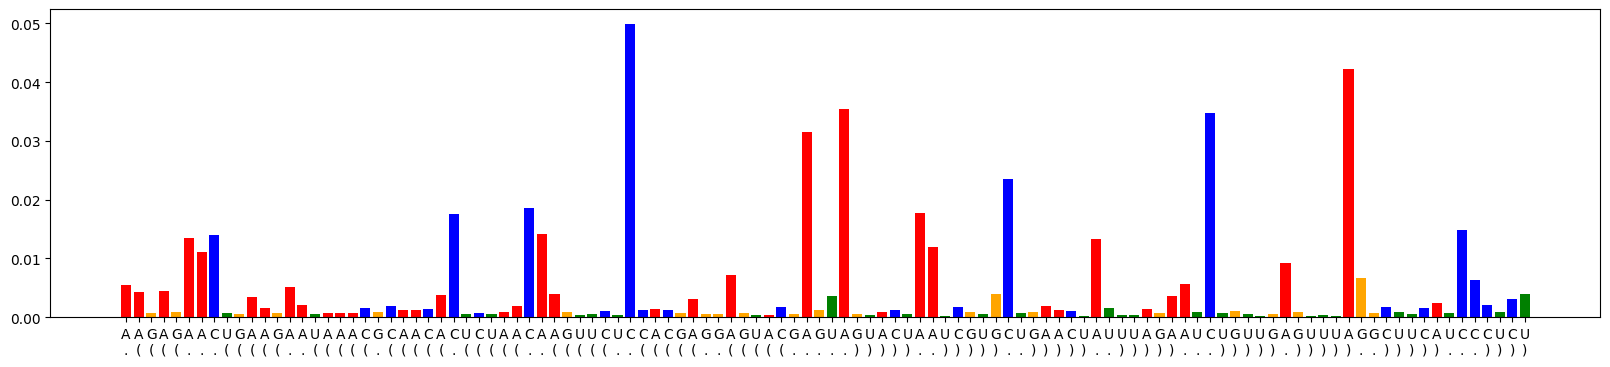

In [30]:
plot_pop_avg_from_row(df_constructs.query('name == "construct1191"').iloc[0])

<Axes: >

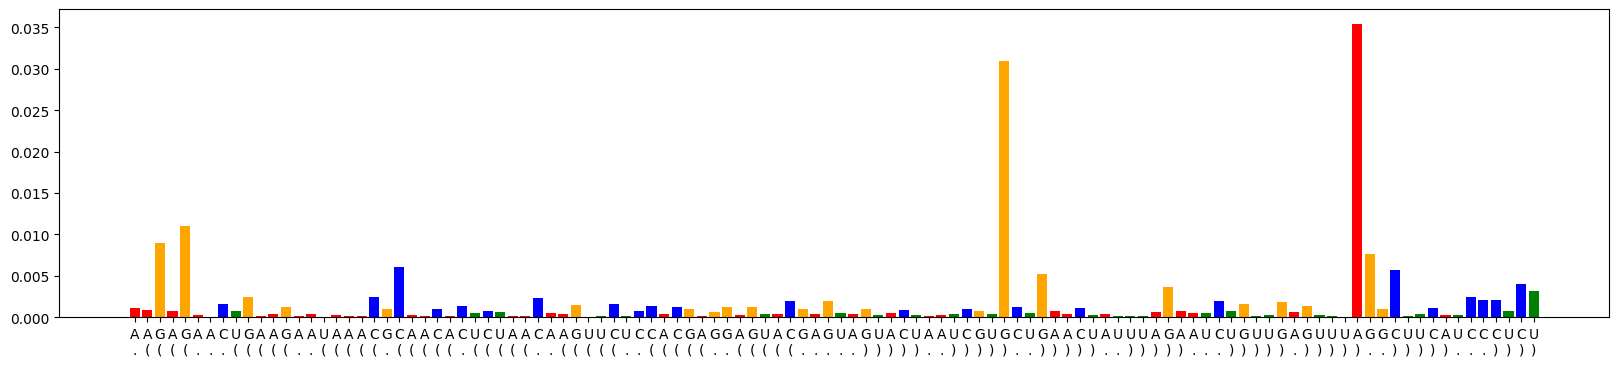

In [31]:
plot_pop_avg_from_row(df_constructs_nomod.query('name == "construct1191"').iloc[0])

In [32]:
df_constructs.query('name == "construct1191"').iloc[0]["sequence"]

'AAGAGAACUGAAGAAUAAACGCAACACUCUAACAAGUUCUCCACGAGGAGUACGAGUAGUACUAAUCGUGCUGAACUAUUUAGAAUCUGUUGAGUUUAGGCUUCAUCCCUCU'

<Axes: >

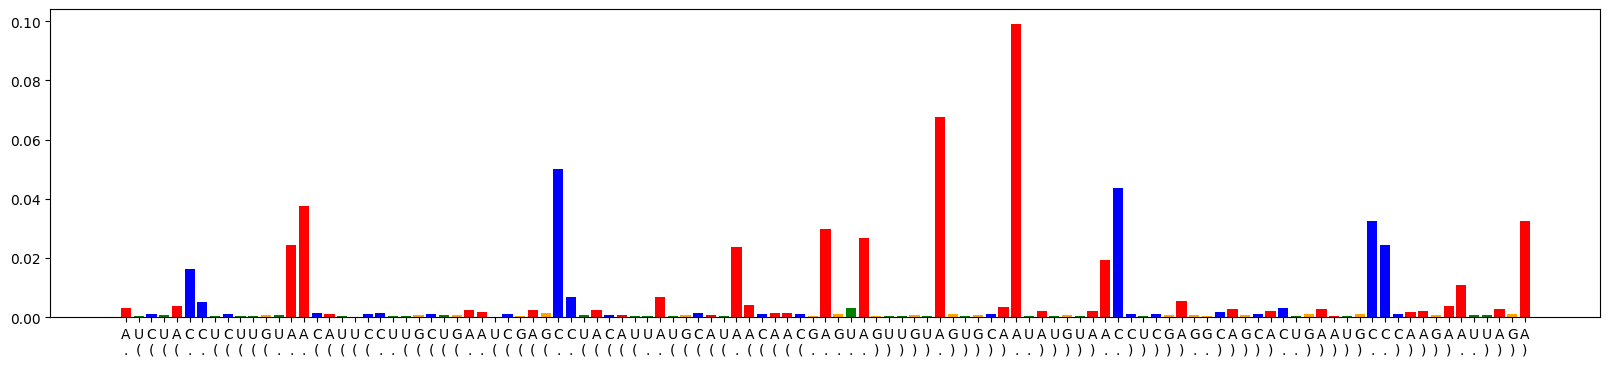

In [33]:
plot_pop_avg_from_row(df_constructs.query('name == "construct3320"').iloc[0])

<Axes: >

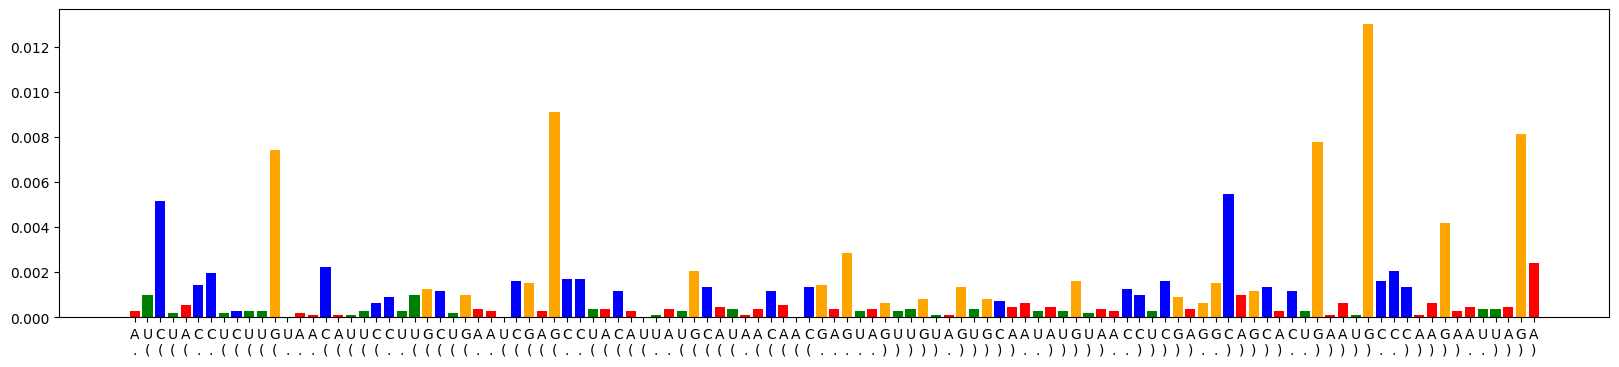

In [34]:
plot_pop_avg_from_row(df_constructs_nomod.query('name == "construct3320"').iloc[0])

In [35]:
df_pos = df_wc.query("m_sequence == 'AGGC&GAAU' and r_loc_pos == 0").copy()

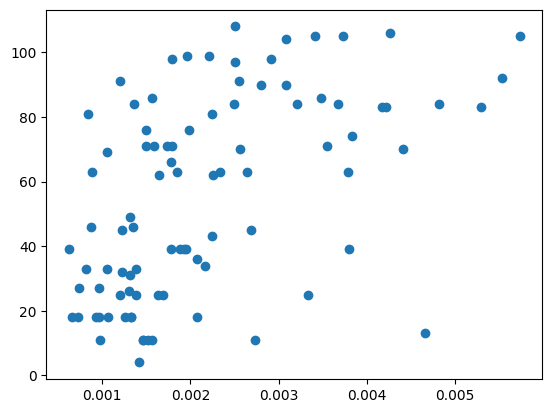

In [36]:
plt.scatter(df_pos["r_data"], df_pos["r_pos"])

<Axes: xlabel='r_data', ylabel='stack'>

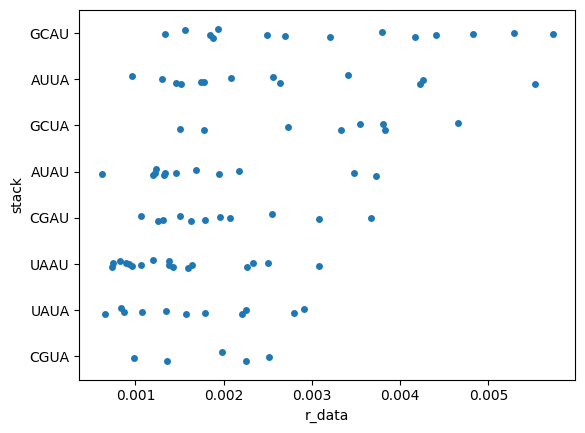

In [37]:
df_pos["stack"] = df_pos["m_second_flank_bp_5p"] + df_pos["m_second_flank_bp_3p"]
sns.stripplot(x="r_data", y="stack", data=df_pos, jitter=True)

#### AAAG&CCGU

In [38]:
df_wc.query("m_sequence == 'AAAG&CCGU' and r_loc_pos == 0 and ln_r_data < -5.45")

,both_purine,both_pyrimidine,constructs,has_pdbs,likely_pair,m_flank_bp_5p,m_flank_bp_3p,m_orientation,m_pos,m_second_flank_bp_5p,...,r_data,r_nuc,r_loc_pos,r_pos,r_type,pdb_path,pdb_r_pos,ln_r_data,z_score,r_data_outlier
9115,False,False,construct5038,False,AU,AU,GC,flipped,2,UA,...,0.00428,A,0,91,WC,[],3,-5.453802,-0.923256,False
9122,False,False,construct5499,False,AU,AU,GC,flipped,1,AU,...,0.00419,A,0,98,WC,[],3,-5.475055,-0.938089,False
9098,False,False,construct2495,False,AU,AU,GC,flipped,5,GC,...,0.00243,A,0,70,WC,[],3,-6.019864,-1.228146,False
9086,False,False,construct884,False,AU,AU,GC,flipped,2,UA,...,0.00193,A,0,91,WC,[],3,-6.250235,-1.310548,False


(0.0, 0.05)

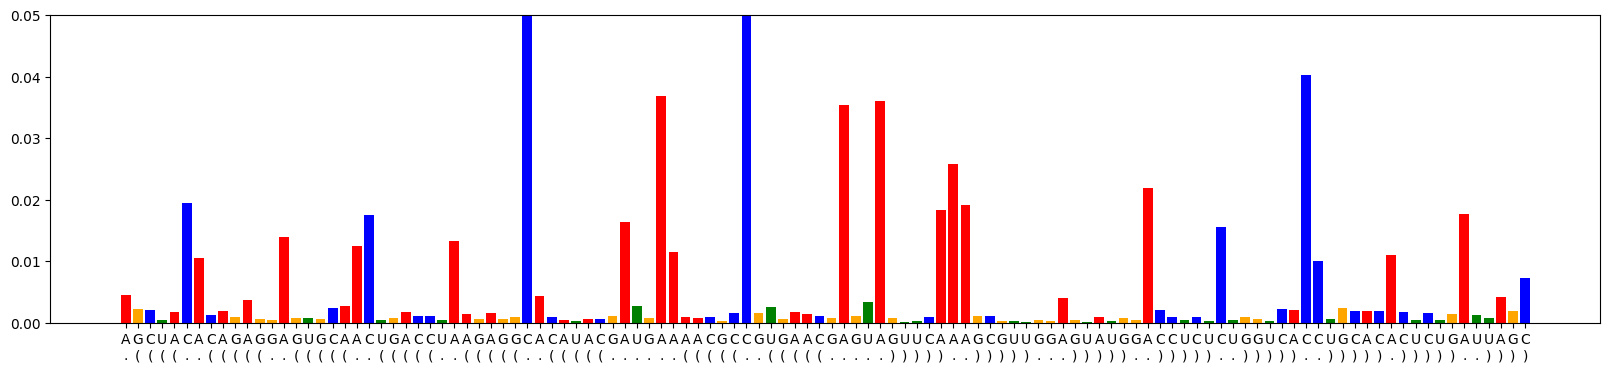

In [39]:
plot_pop_avg_from_row(df_constructs.query('name == "construct793"').iloc[0])
plt.ylim(0, 0.05)

<Axes: >

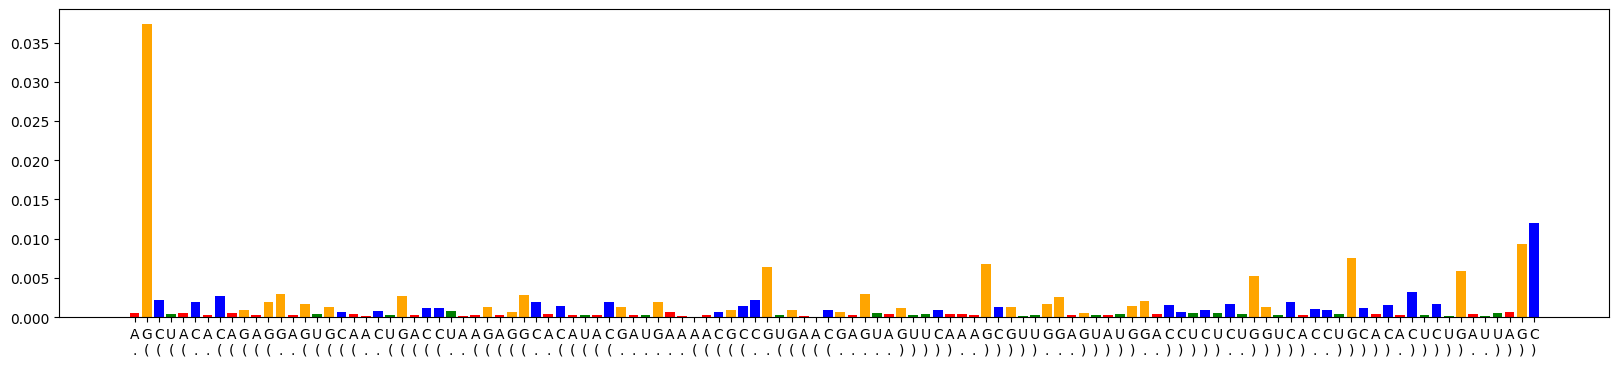

In [40]:
plot_pop_avg_from_row(df_constructs_nomod.query('name == "construct793"').iloc[0])

(0.0, 0.05)

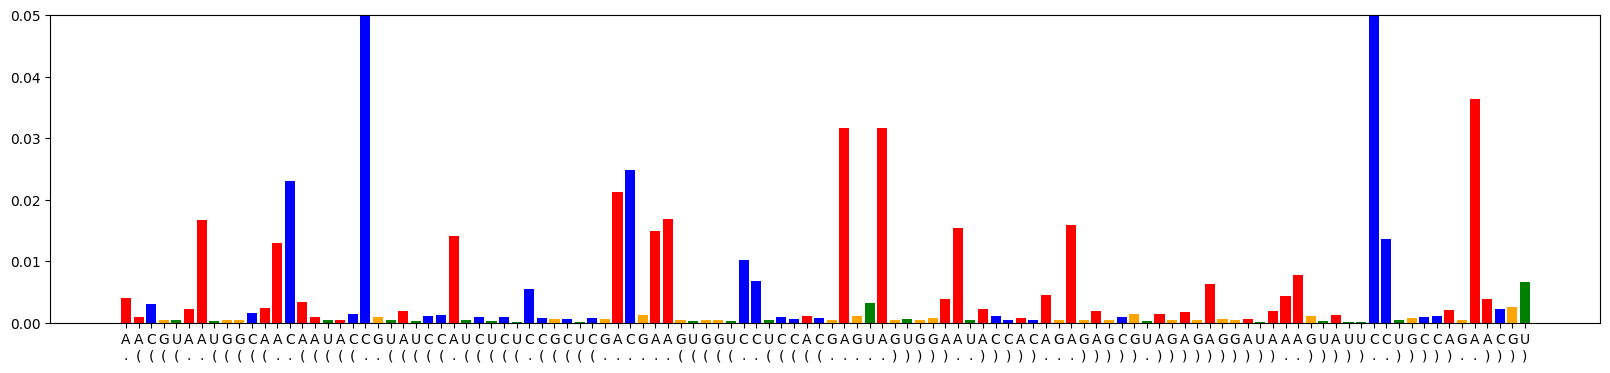

In [41]:
plot_pop_avg_from_row(df_constructs.query('name == "construct884"').iloc[0])
plt.ylim(0, 0.05)

<Axes: >

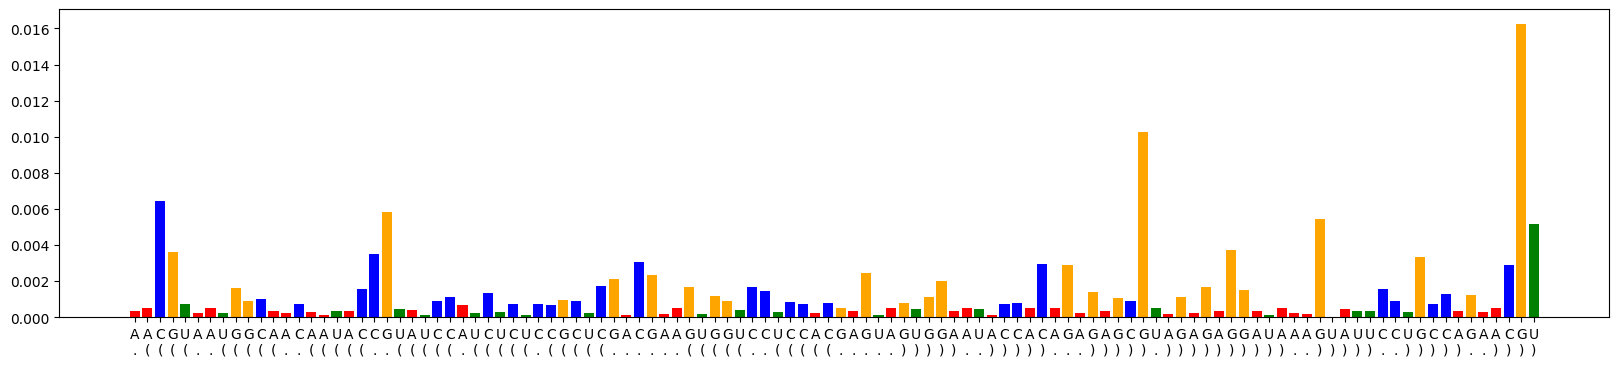

In [42]:
plot_pop_avg_from_row(df_constructs_nomod.query('name == "construct884"').iloc[0])

In [43]:
df_pos = df_wc.query("m_sequence == 'AAAG&CCGU' and r_loc_pos == 0").copy()

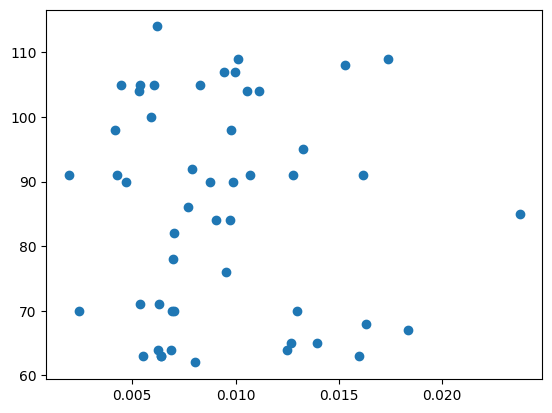

In [44]:
plt.scatter(df_pos["r_data"], df_pos["r_pos"])

<Axes: xlabel='r_data', ylabel='m_second_flank_bp_3p'>

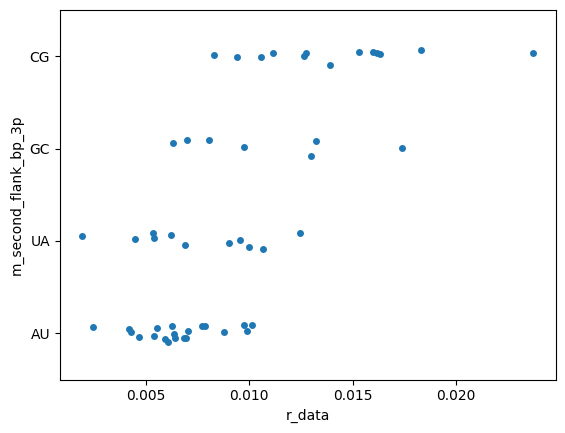

In [45]:
sns.stripplot(x="r_data", y="m_second_flank_bp_3p", data=df_pos, jitter=True)

<Axes: xlabel='r_data', ylabel='stack'>

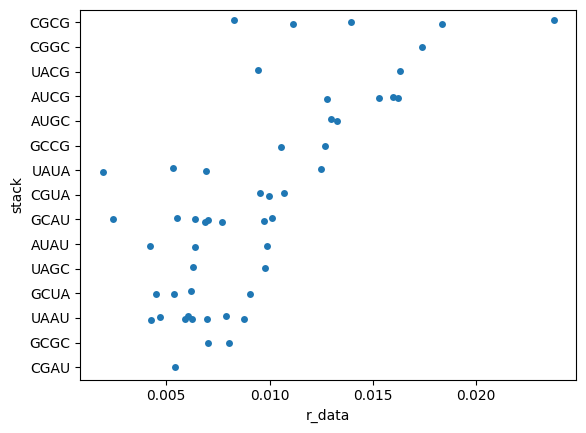

In [46]:
df_pos["stack"] = df_pos["m_second_flank_bp_5p"] + df_pos["m_second_flank_bp_3p"]
sns.stripplot(x="r_data", y="stack", data=df_pos, jitter=True)

In [47]:
first_10_unique = df_wc_high.drop_duplicates(subset='m_sequence', keep='first').head(50)
first_10_unique["m_sequence"].values   

array(['AAUG&CCAU', 'AACG&CCAU', 'AAUA&UCAU', 'AAUC&GCAU', 'AAUG&CUGU',
       'AACA&UCAU', 'UCAA&UGAA', 'CAAA&UCAG', 'GUGA&UAUC', 'AAAG&CCGU',
       'AUGA&UAUU', 'AACC&GCAU', 'CCAA&UAAG', 'UAUA&UUGA', 'CGAA&UCAG',
       'ACAUG&CU', 'AAUA&UUGU', 'AGAA&UCAU', 'AAAG&CCAU', 'UAAG&CA',
       'UAC&GA', 'AAAA&UCAU', 'UAUGUAG&UGAAA', 'CAGA&UGAG', 'CCGA&UAAG',
       'GCAA&UAAC', 'UAAA&UCAA', 'CUAA&UACG', 'GCAA&UACC', 'AUAG&CACU',
       'CUGA&UAUG', 'GGAA&UCAC', 'CAGA&UAAG', 'UAAU&AA', 'ACAA&UACU',
       'CGA&UAG', 'GUAA&UACC', 'GCCA&UACC', 'UACA&UUAA', 'AAUC&GUGU',
       'UAAA&UGGA', 'AACU&AUAU', 'UGCA&UUGA', 'AAGA&UGAU', 'ACAA&UAAU',
       'AACU&ACAU', 'CAA&UG', 'GACA&UUAC', 'GAAA&UCAC', 'UACA&UCAA'],
      dtype=object)

In [48]:
df_residue_avg.sort_values("r_data", inplace=True, ascending=False)
first_10_unique = df_residue_avg.drop_duplicates(subset='m_sequence', keep='first').head(50)